In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, TimeDistributed, Flatten, Dense
from keras.callbacks import EarlyStopping

# Thiết lập thiết bị
import tensorflow as tf
print("Số lượng GPU khả dụng: ", len(tf.config.list_physical_devices('GPU')))

2025-12-22 04:48:11.280791: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-22 04:48:11.313279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-22 04:48:12.250572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-22 04:48:16.652099: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Số lượng GPU khả dụng:  0


2025-12-22 04:48:17.617028: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# 1. Tải dữ liệu
df = pd.read_csv("../data/yfinance_data2.csv")
df['date'] = pd.to_datetime(df['date'])
ticker = 'NVDA' 
data = df[df['symbol'] == ticker].sort_values('date')
data["band_width"] = data["upper_band"] - data["lower_band"]

features_cols = ['close_price','volume', 
                  'MACD', 'RSI', 'ATR', 'return_pct', 'volatility_14', 'band_width']
dataset = data[features_cols].values

# 3. Chuẩn hóa Min-Max (Giúp LSTM hội tụ tốt hơn Standard)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 4. Tạo cấu trúc dữ liệu cho TimeDistributed CNN-LSTM
def create_complex_sequences(data, n_steps, n_seq, n_features):
    X, y = [], []
    window_size = n_steps * n_seq
    for i in range(window_size, len(data)):
        seq_x = data[i-window_size:i, :]
        X.append(seq_x.reshape((n_seq, n_steps, n_features)))
        y.append(data[i, 0]) # Dự báo giá Close
    return np.array(X), np.array(y)

N_STEPS = 10
N_SEQ = 5
N_FEATURES = len(features_cols)

X, y = create_complex_sequences(scaled_data, N_STEPS, N_SEQ, N_FEATURES)

# Chia Train/Test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Shape đầu vào (X_train): {X_train.shape}") # (samples, 5, 10, 12)

Shape đầu vào (X_train): (2148, 5, 10, 8)


In [4]:
model = Sequential()

# Tầng CNN bọc trong TimeDistributed
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'), 
                           input_shape=(N_SEQ, N_STEPS, N_FEATURES)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# Tầng Bidirectional LSTM (Học hai chiều)
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

# Tầng đầu ra
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 10, 64)      │         1,600 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 5, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 320)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 5, 200)         │       336,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,401 (2.21 MB)

 Trainable params: 579,401 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.0055 - val_loss: 0.0332
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8769e-04 - val_loss: 0.0187
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1394e-04 - val_loss: 0.0154
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.6628e-04 - val_loss: 0.0073
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7545e-04 - val_loss: 0.0096
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2796e-04 - val_loss: 0.0088
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5075e-04 - val_loss: 0.0182
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0124e-04 - val_loss: 0.0121
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0266e-04 - val_loss: 0.0134
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1505e-04 - val_loss: 0.0171
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6269e-05 - val_loss: 0.0111
Epoch 12/100

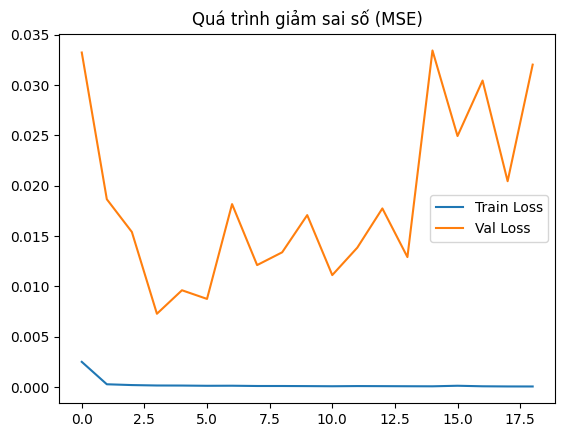

In [5]:
# Tự động dừng nếu loss không giảm để tránh Overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Vẽ đồ thị Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Quá trình giảm sai số (MSE)")
plt.show()

In [ ]:
# 1. Dự báo trên tập Test
predictions_scaled = model.predict(X_test)

# 2. Đảo ngược chuẩn hóa đúng cách
def inverse_transform_col0(scaled_val, scaler, n_features):
    dummy = np.zeros((len(scaled_val), n_features))
    dummy[:, 0] = scaled_val.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

inv_predictions = inverse_transform_col0(predictions_scaled, scaler, N_FEATURES)
inv_y_test = inverse_transform_col0(y_test, scaler, N_FEATURES)

# 3. Tính toán các chỉ số
mse = mean_squared_error(inv_y_test, inv_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_y_test, inv_predictions)
r2 = r2_score(inv_y_test, inv_predictions)
mape = np.mean(np.abs((inv_y_test - inv_predictions) / inv_y_test)) * 100

print(f"--- KẾT QUẢ ĐÁNH GIÁ CHI TIẾT ---")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE (Sai số %): {mape:.2f}%")

# 4. CHUẨN BỊ DỮ LIỆU VẼ BIỂU ĐỒ (Đồng bộ với trục thời gian)
# Lấy các mốc thời gian tương ứng với tập Test
# Tập Test bắt đầu sau tập Train và Window Offset
window_offset = N_SEQ * N_STEPS
test_dates = data['date'].iloc[split + window_offset:].values

# 5. TRỰC QUAN HÓA 
plt.figure(figsize=(15, 7))

# Vẽ đường giá thực tế
plt.plot(test_dates, inv_y_test, label='Giá thực tế (Actual)', color='black', linewidth=1.5)

# Vẽ đường dự báo
plt.plot(test_dates, inv_predictions, label='Giá dự báo (Bi-LSTM CNN)', color='orange', linestyle='--', linewidth=1.5)

plt.title(f"DỰ BÁO GIÁ CỔ PHIẾU {ticker} (Giai đoạn kiểm tra)", fontsize=16)
plt.xlabel("THỜI GIAN (Ngày/Tháng/Năm)", fontsize=12) 
plt.ylabel("GIÁ CỔ PHIẾU (USD)", fontsize=12)         

plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.gcf().autofmt_xdate() 

plt.show()

In [ ]:
# 6. Tạo cấu trúc dữ liệu cho LSTM đơn giản 
def create_lstm_sequences(data, window_size, n_features):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])  
        y.append(data[i, 0]) 
    return np.array(X), np.array(y)

WINDOW_SIZE = N_SEQ * N_STEPS  
X_lstm, y_lstm = create_lstm_sequences(scaled_data, WINDOW_SIZE, N_FEATURES)


split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

print(f"Shape đầu vào LSTM (X_train_lstm): {X_train_lstm.shape}")  

In [ ]:
# 7. Xây dựng mô hình LSTM đơn giản (tương tự phần LSTM của mô hình gốc)
model_lstm = Sequential()

# Tầng Bidirectional LSTM
model_lstm.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(WINDOW_SIZE, N_FEATURES)))
model_lstm.add(Dropout(0.25))
model_lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
model_lstm.add(Dropout(0.5))

# Tầng đầu ra
model_lstm.add(Dense(1, activation='linear'))

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

In [8]:
# 8. Train mô hình LSTM (giống cấu hình của mô hình gốc)
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop]
)

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 5.8762e-04 - val_loss: 3.1191e-04
Epoch 24/100
 5/61 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.5522e-04

KeyboardInterrupt: 

In [ ]:
# 9. Dự báo trên tập Test cho LSTM
predictions_scaled_lstm = model_lstm.predict(X_test_lstm)

# Đảo ngược chuẩn hóa (sử dụng hàm giống mô hình gốc)
inv_predictions_lstm = inverse_transform_col0(predictions_scaled_lstm, scaler, N_FEATURES)
inv_y_test_lstm = inverse_transform_col0(y_test_lstm, scaler, N_FEATURES)  # y_test giống mô hình gốc

# Tính toán các chỉ số cho LSTM
mse_lstm = mean_squared_error(inv_y_test_lstm, inv_predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(inv_y_test_lstm, inv_predictions_lstm)
r2_lstm = r2_score(inv_y_test_lstm, inv_predictions_lstm)
mape_lstm = np.mean(np.abs((inv_y_test_lstm - inv_predictions_lstm) / inv_y_test_lstm)) * 100

print("--- KẾT QUẢ ĐÁNH GIÁ CHI TIẾT CHO LSTM ---")
print(f"MSE: {mse_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAE: {mae_lstm:.4f}")
print(f"R-squared: {r2_lstm:.4f}")
print(f"MAPE (Sai số %): {mape_lstm:.2f}%")

# Vẽ biểu đồ cho LSTM (tương tự mô hình gốc)
plt.figure(figsize=(15, 7))
plt.plot(test_dates, inv_y_test_lstm, label='Giá thực tế (Actual)', color='black', linewidth=1.5)
plt.plot(test_dates, inv_predictions_lstm, label='Giá dự báo (LSTM)', color='blue', linestyle='--', linewidth=1.5)
plt.title(f"DỰ BÁO GIÁ CỔ PHIẾU {ticker} (Giai đoạn kiểm tra - LSTM)", fontsize=16)
plt.xlabel("THỜI GIAN (Ngày/Tháng/Năm)", fontsize=12)
plt.ylabel("GIÁ CỔ PHIẾU (USD)", fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# 10. So sánh chỉ số giữa CNN-LSTM và LSTM (lấy từ các biến đã tính trước)
metrics = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R-squared', 'MAPE (%)'],
    'CNN-LSTM': [mse, rmse, mae, r2, mape],
    'LSTM': [mse_lstm, rmse_lstm, mae_lstm, r2_lstm, mape_lstm]
}

comparison_df = pd.DataFrame(metrics)
print("--- SO SÁNH CHỈ SỐ GIỮA HAI MÔ HÌNH ---")
print(comparison_df.to_string(index=False))

# Vẽ biểu đồ so sánh (bar chart cho các chỉ số lỗi)
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title("So sánh chỉ số đánh giá giữa CNN-LSTM và LSTM")
plt.ylabel("Giá trị")
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 11. Visualize giá thực tế và dự báo của cả 2 mô hình trên 10 ngày cuối cùng

# Lấy 10 ngày cuối của tập test
N_LAST_DAYS = 10
last_dates = test_dates[-N_LAST_DAYS:]
last_actual = inv_y_test[-N_LAST_DAYS:]
last_pred_cnn_lstm = inv_predictions[-N_LAST_DAYS:]
last_pred_lstm = inv_predictions_lstm[-N_LAST_DAYS:]

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Giá thực tế
plt.plot(last_dates, last_actual, label='Giá thực tế (Actual)', 
         color='black', linewidth=2.5, marker='o')

# Dự báo CNN-LSTM
plt.plot(last_dates, last_pred_cnn_lstm, label='Dự báo CNN-LSTM', 
         color='orange', linewidth=2, linestyle='--', marker='^')

# Dự báo LSTM
plt.plot(last_dates, last_pred_lstm, label='Dự báo LSTM thuần', 
         color='blue', linewidth=2, linestyle='-.', marker='s')

# Thiết lập
plt.title(f'SO SÁNH DỰ BÁO GIÁ CỔ PHIẾU {ticker} - 10 NGÀY CUỐI CÙNG', fontsize=16, pad=20)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá đóng cửa (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Định dạng ngày đẹp hơn
plt.gcf().autofmt_xdate()

# Thêm giá trị cụ thể lên từng điểm để dễ so sánh
for i, date in enumerate(last_dates):
    plt.text(date, last_actual[i], f'{last_actual[i]:.2f}', 
             fontsize=9, ha='right', va='bottom', color='black')
    plt.text(date, last_pred_cnn_lstm[i], f'{last_pred_cnn_lstm[i]:.2f}', 
             fontsize=9, ha='left', va='bottom', color='orange')
    plt.text(date, last_pred_lstm[i], f'{last_pred_lstm[i]:.2f}', 
             fontsize=9, ha='center', va='top', color='blue')

plt.tight_layout()
plt.show()